# Three Decision tree models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

**I am going to use the kyphosis dataset Representing the number of patiens who has this medical spinal condition which had a surgery showing if this condition was present or absent after the operation**

In [2]:
df = pd.read_csv("kyphosis.csv")

In [3]:
df.head()

,Kyphosis,Age,Number,Start
0,absent,71,3,5
1,absent,158,3,14
2,present,128,4,5
3,absent,2,5,1
4,absent,1,4,15


1. Kyphosis: present or absent after the operation

2. Age: in month because these are children

3. Number: Number of vertebrae involved in the operation

4. Start: Number or top most vertabrae that was operated on

There are 7 cervical vertebrae, 12 in the torax region, and 5 lumbar, and the sacro coxis region are merged.

# EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Kyphosis  81 non-null     object
 1   Age       81 non-null     int64 
 2   Number    81 non-null     int64 
 3   Start     81 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 2.7+ KB


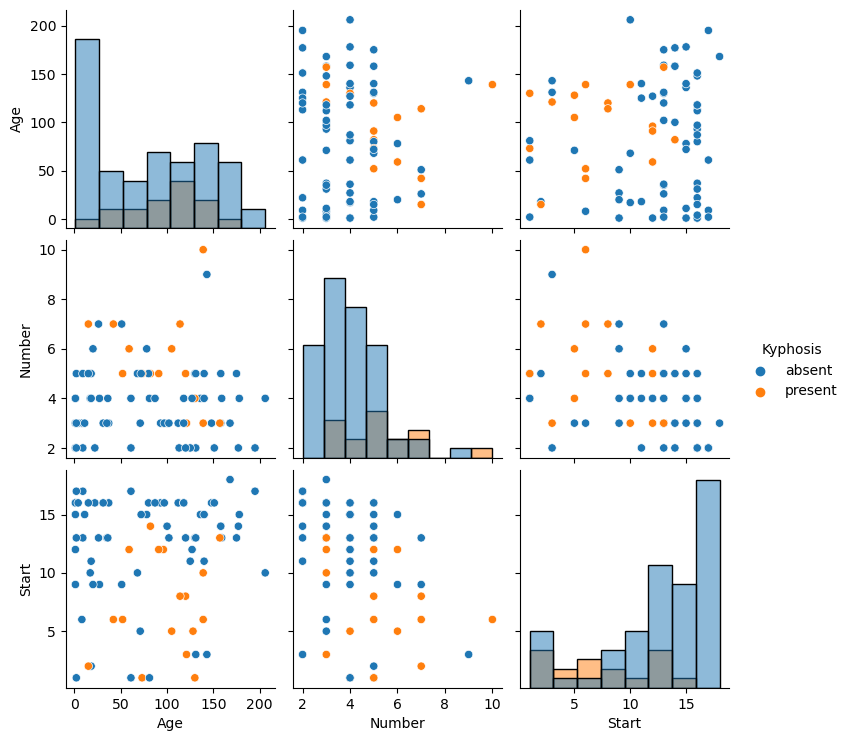

In [5]:
sns.pairplot(df, hue = "Kyphosis", diag_kind = "hist")
plt.show()

# **Training and testing our data**

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X = df.drop("Kyphosis", axis = 1)

y = df["Kyphosis"] # The objective is to predict if the Kyphosis is present or not for unseen data based on this data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Decision tree classifier

In [9]:
from sklearn.tree import DecisionTreeClassifier # We are predicting categorical data
from sklearn.tree import plot_tree

In [10]:
dtree = DecisionTreeClassifier()

In [11]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [12]:
dtree.fit(X_train, y_train).get_params() # we are going to focus on ccp_alpha, adjusting that parameter to optimize our model

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [13]:
predictions = dtree.predict(X_test)

# Error Metrics

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

In [15]:
print(print(confusion_matrix(y_test, predictions)))
print()
print(classification_report(y_test, predictions, target_names = ["present", "absent"]))

[[17  2]
 [ 4  2]]
None

              precision    recall  f1-score   support

     present       0.81      0.89      0.85        19
      absent       0.50      0.33      0.40         6

    accuracy                           0.76        25
   macro avg       0.65      0.61      0.62        25
weighted avg       0.74      0.76      0.74        25



In [16]:
CM = confusion_matrix(y_test, predictions)

In [17]:
CM = pd.DataFrame(CM, index = ["Present", "Absent"], columns = ["Present", "Absent"])

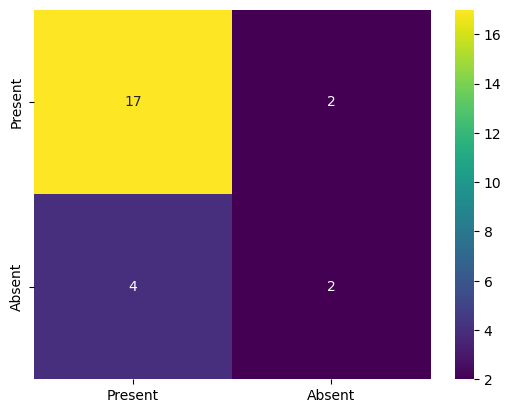

In [18]:
sns.heatmap(CM, annot = True, cmap = "viridis")
plt.show()

# **We are going to draw the decision tree**

In [19]:
X.columns

Index(['Age', 'Number', 'Start'], dtype='object')

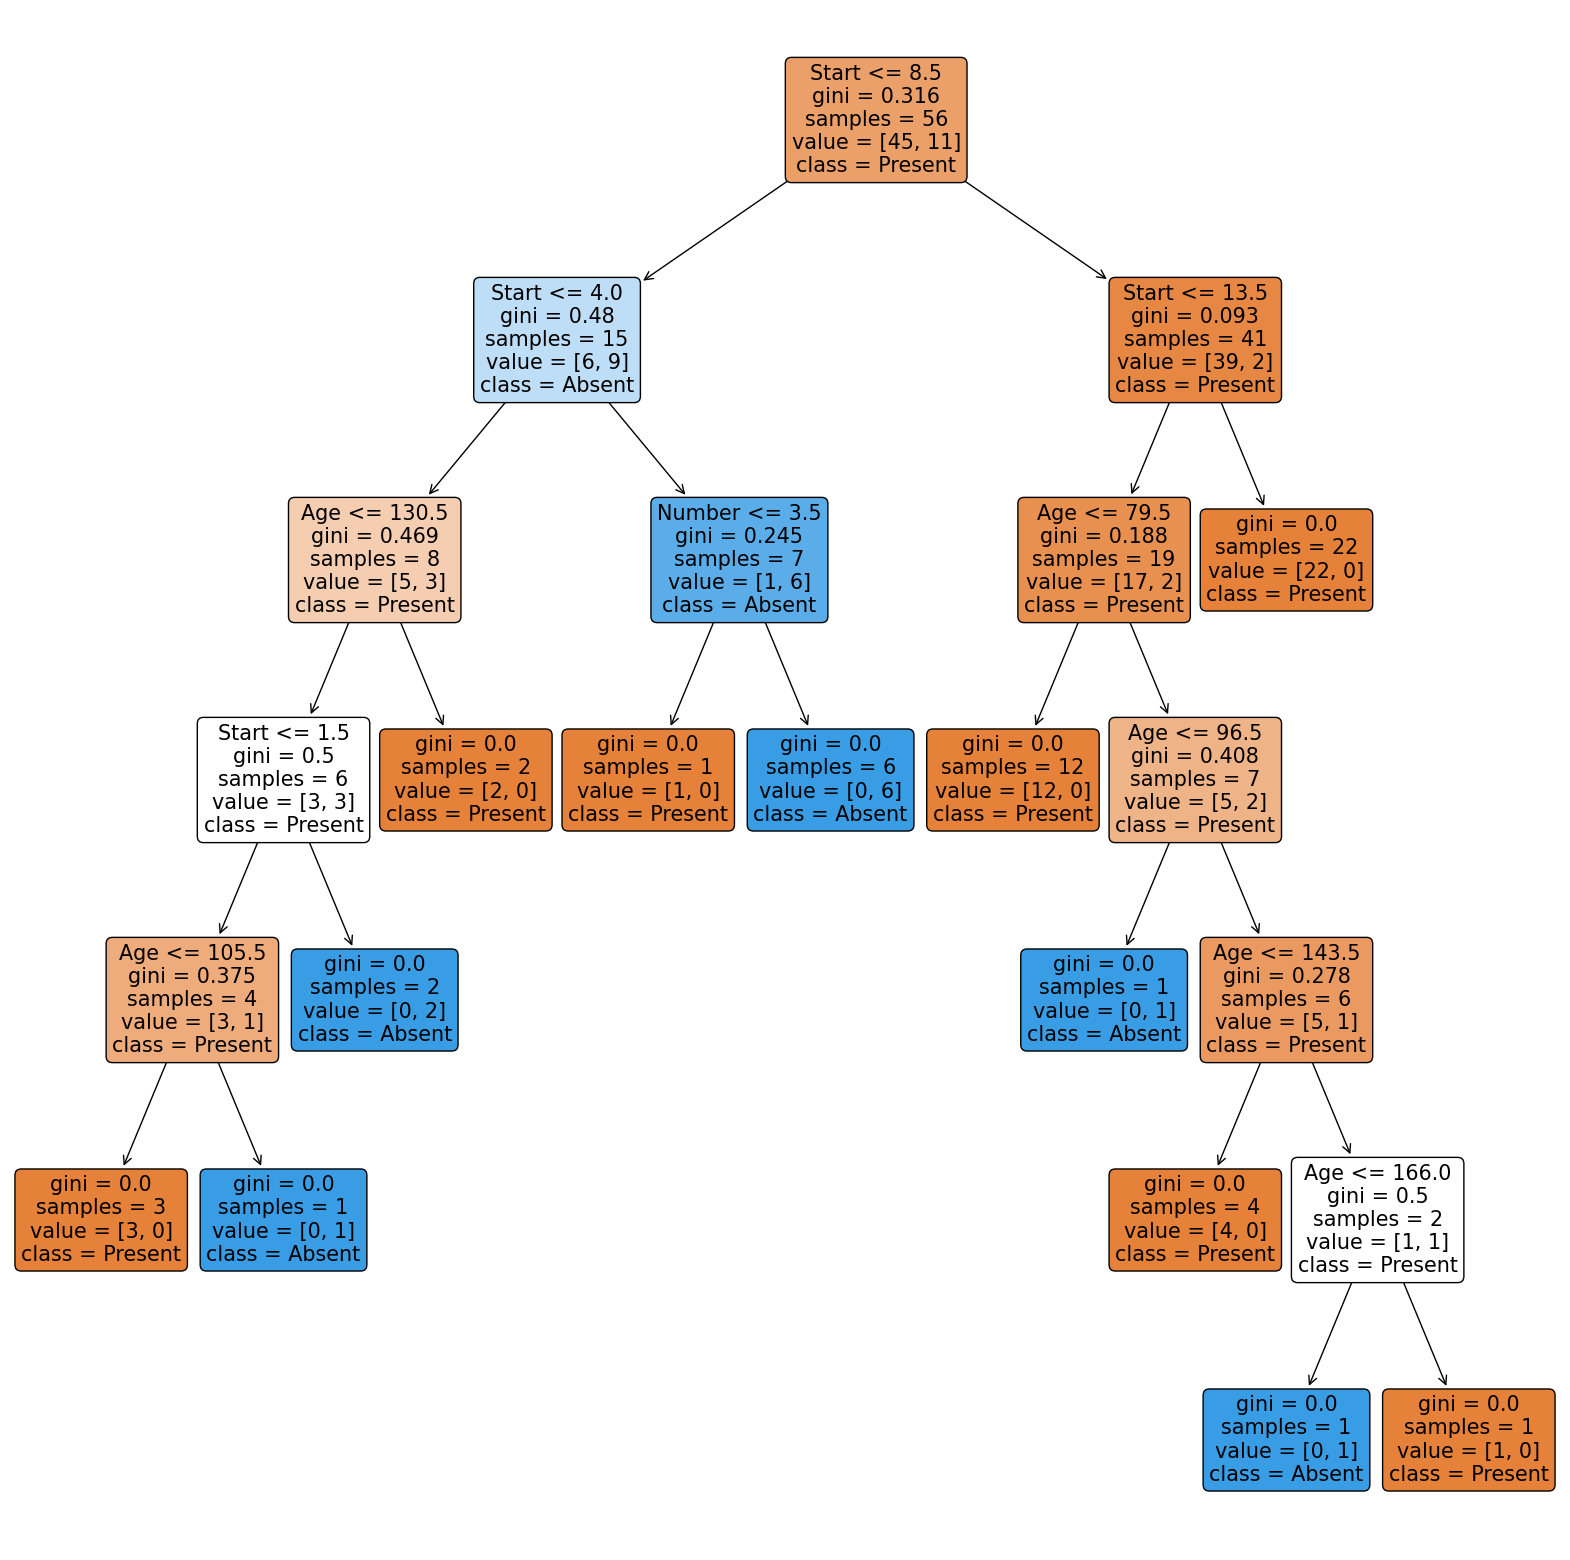

In [20]:
plt.figure(figsize = (20, 20))
fig = plot_tree(dtree, 
                filled = True, 
                rounded = True, 
                class_names= ["Present", "Absent"], 
                feature_names = ['Age', 'Number', 'Start'])

# Cost complexity pruning

# -Finding the best alpha based on the score per tree

Decision trees overfit the training dataset more often, there are parameters like **max_depth** and **min_samples** to prune the tree and reduce the overfiting, but we can prune it with **cost complexity pruning**. This simplifies the whole process to find a optimal tree for unseen data, the test data. 

The question is: What is the right value for the pruning parameter? The parameter we are going to look at is the **alpha** to see how little or how much pruning happens to find the optimal value.

In order to see the optimal value of alpha we are going to see and plot the accuracy of many trees with different alpha values, a function of different values, we are going to do this in **the training** and **testing dataset**. 

Let's extract different values of alpha for the tree We have built already building a prune tree for each value of alpha, but we are going to **omit the last value of alpha** because it would prune all leaves leaving us with only a root instead of a tree. 

In [21]:
path = dtree.cost_complexity_pruning_path(X_train, y_train) # determine the values for alpha, and impuritie leaves

In [22]:
path

{'ccp_alphas': array([0.        , 0.01358885, 0.02232143, 0.03061224, 0.0309949 ,
        0.1191731 ]),
 'impurities': array([0.        , 0.06794425, 0.13490854, 0.16552078, 0.19651568,
        0.31568878])}

In [23]:
ccp_alphas = path.ccp_alphas # we are going to select only the alphas
ccp_alphas

array([0.        , 0.01358885, 0.02232143, 0.03061224, 0.0309949 ,
       0.1191731 ])

In [24]:
ccp_alphas = ccp_alphas[: -1] # excluding the maximum value

In [25]:
ccp_alphas

array([0.        , 0.01358885, 0.02232143, 0.03061224, 0.0309949 ])

In [26]:
n_dtrees = [] # we are going to store here the decision trees with different alphas 

In [27]:
for alpha in ccp_alphas:
    dtree2 = DecisionTreeClassifier(random_state = 0, ccp_alpha = alpha)
    dtree2.fit(X_train, y_train)
    n_dtrees.append(dtree2)    

In [28]:
n_dtrees

[DecisionTreeClassifier(random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.013588850174216025, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.022321428571428572, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.03061224489795919, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.030994897959183657, random_state=0)]

**Let's draw the train and test scores**

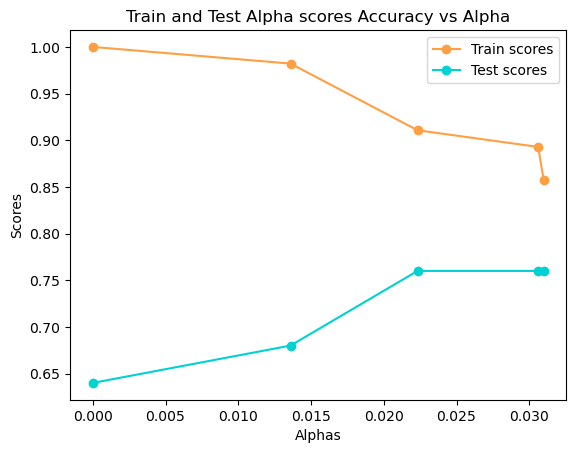

In [29]:
#The .score() attribute of a decision tree object in scikit-learn returns the mean accuracy of the tree on a given dataset. 
#The accuracy is calculated by comparing the predicted labels of the tree to the true labels of the dataset.

train_scores = [dtree.score(X_train, y_train) for dtree in n_dtrees]
test_scores = [dtree.score(X_test, y_test) for dtree in n_dtrees]

plt.plot(ccp_alphas, train_scores, marker = "o", label = "Train scores", color = "#ff9f43")
plt.plot(ccp_alphas, test_scores, marker = "o", label = "Test scores", color = "#00d2d3")
plt.title("Train and Test Alpha scores Accuracy vs Alpha")
plt.xlabel("Alphas")
plt.ylabel("Scores")
plt.legend()
plt.show()

**Now we need to select the best alpha based on the highest test score because we want to generalize the model for useen data**

In [30]:
pd.DataFrame({"test_scores" : test_scores, "alpha" : ccp_alphas})

,test_scores,alpha
0,0.64,0.000000
1,0.68,0.013589
2,0.76,0.022321
3,0.76,0.030612
4,0.76,0.030995


In [31]:
alpha_test = pd.DataFrame({"test_scores" : test_scores, "alpha" : ccp_alphas})

alpha_test[alpha_test["test_scores"] == max(alpha_test["test_scores"])]

,test_scores,alpha
2,0.76,0.022321
3,0.76,0.030612
4,0.76,0.030995


In [32]:
best_alpha_ccp = round(alpha_test[alpha_test["test_scores"] == max(alpha_test["test_scores"])].iloc[0, 1], 3)

In [33]:
best_alpha_ccp # this is the a good alpha value to optimize our model

0.022

# Cost complexity pruning

# -Finding the best alpha based on the cross validation score

In [34]:
from sklearn.model_selection import cross_val_score

In [35]:
dtree = DecisionTreeClassifier(random_state = 0, ccp_alpha = best_alpha_ccp) 
# we selected the alpha value based on the previous chart

In [36]:
scores = cross_val_score(dtree, X_train, y_train, cv = 5) # we are going to use 5 k folds

In [37]:
scores

array([0.66666667, 0.81818182, 0.90909091, 0.81818182, 0.81818182])

In [38]:
df_accuracy_tree = pd.DataFrame({"Accuracy" : scores, "Tree" : range(5)})

In [39]:
df_accuracy_tree

,Accuracy,Tree
0,0.666667,0
1,0.818182,1
2,0.909091,2
3,0.818182,3
4,0.818182,4


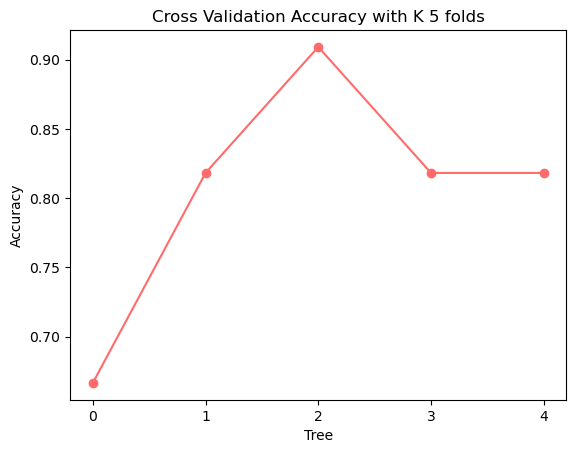

In [40]:
plt.plot(df_accuracy_tree["Tree"], df_accuracy_tree["Accuracy"], marker ="o", color = "#ff6b6b")
plt.xlabel("Tree")
plt.ylabel("Accuracy")
plt.title("Cross Validation Accuracy with K 5 folds")
plt.xticks(df_accuracy_tree["Tree"])
plt.show()

Using different **X_train and y_train datasets** with the **same alpha** results in different levels of accuracy, this suggest that alpha is sensitive to the datasets, let's use cross validation to find the **optimal value for cost complexity pruning alpha** this time.

In [41]:
cross_alpha = [] # here we are going to store all the trees with cross validation selecting the best alpha

In [42]:
for ccp_alpha in ccp_alphas: # Remember, these cc_alphas are the alphas of the cost complexity pruning list
    
    dtree2 = DecisionTreeClassifier(random_state = 0, ccp_alpha = ccp_alpha) # one alpha
    scores = cross_val_score(dtree2, X_train, y_train, cv = 5) # 6 scores with the same alpha
    
    # we are going to average the scores because we have 6, but just one alpha and one decision tree per iteration
    cross_alpha.append([dtree2, np.mean(scores), np.std(scores), ccp_alpha])     
    

cross_alpha

[[DecisionTreeClassifier(random_state=0), 0.7318181818181817, 0.1, 0.0],
 [DecisionTreeClassifier(ccp_alpha=0.013588850174216025, random_state=0),
  0.7318181818181817,
  0.1,
  0.013588850174216025],
 [DecisionTreeClassifier(ccp_alpha=0.022321428571428572, random_state=0),
  0.806060606060606,
  0.07808544682863713,
  0.022321428571428572],
 [DecisionTreeClassifier(ccp_alpha=0.03061224489795919, random_state=0),
  0.806060606060606,
  0.07808544682863713,
  0.03061224489795919],
 [DecisionTreeClassifier(ccp_alpha=0.030994897959183657, random_state=0),
  0.8227272727272729,
  0.05061603966209109,
  0.030994897959183657]]

In [43]:
dataframe = pd.DataFrame(cross_alpha, columns = ["tree", "mean_scores", "std_scores", "alpha"]) # let's tabulate our data 
dataframe

,tree,mean_scores,std_scores,alpha
0,DecisionTreeClassifier(random_state=0),0.731818,0.100000,0.000000
1,DecisionTreeClassifier(ccp_alpha=0.01358885017...,0.731818,0.100000,0.013589
2,DecisionTreeClassifier(ccp_alpha=0.02232142857...,0.806061,0.078085,0.022321
3,DecisionTreeClassifier(ccp_alpha=0.03061224489...,0.806061,0.078085,0.030612
4,DecisionTreeClassifier(ccp_alpha=0.03099489795...,0.822727,0.050616,0.030995


**Now we are going to plot the mean of the scores cross validated along with its respective alpha and see if we can select a better alpha**

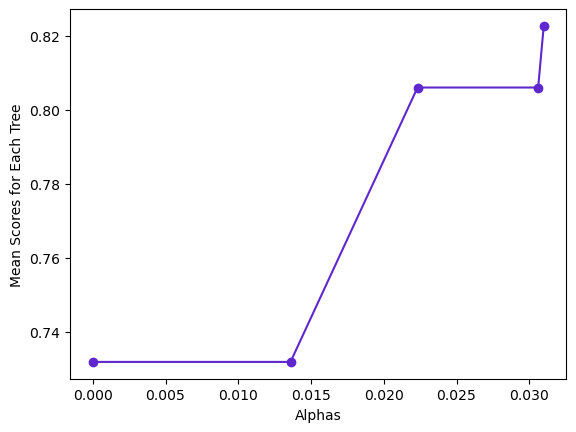

In [44]:
plt.plot(dataframe["alpha"], dataframe["mean_scores"], color = "#5f27cd", marker = "o")
plt.xlabel("Alphas")
plt.ylabel("Mean Scores for Each Tree")
plt.show()

In [45]:
dataframe[dataframe["mean_scores"] == max(dataframe["mean_scores"])]

,tree,mean_scores,std_scores,alpha
4,DecisionTreeClassifier(ccp_alpha=0.03099489795...,0.822727,0.050616,0.030995


In [46]:
best_alpha_cross = round(dataframe[dataframe["mean_scores"] == max(dataframe["mean_scores"])].iloc[0, 3], 3)

In [47]:
best_alpha_cross # This may be a better alpha for our model to generalize and reduce the overfitting. 

0.031

# Building and evaluating the optimized classification tree

In [48]:
dtree_pruned = DecisionTreeClassifier(random_state = 0, ccp_alpha = best_alpha_cross)

In [49]:
dtree_pruned = dtree_pruned.fit(X_train, y_train)

In [50]:
dtree_pruned_pred = dtree_pruned.predict(X_test)

In [51]:
CMP = confusion_matrix(y_test, dtree_pruned_pred) # confusion matrix of the tree pruned

In [52]:
CMP = pd.DataFrame(CMP, index = ["Present", "Absent"], columns = ["Present", "Absent"])

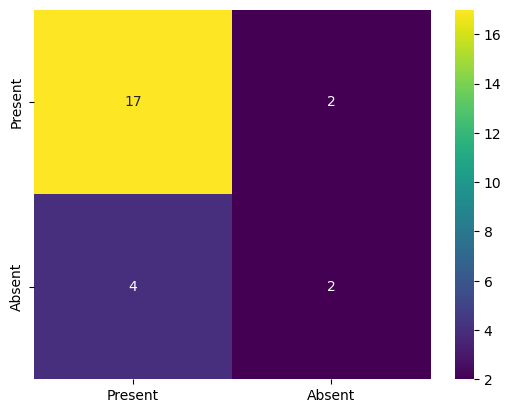

In [53]:
sns.heatmap(CMP, annot = True, cmap = "viridis")
plt.show()

In [54]:
print(classification_report(y_test, dtree_pruned_pred,  target_names = ["present", "absent"]))

              precision    recall  f1-score   support

     present       0.81      0.89      0.85        19
      absent       0.50      0.33      0.40         6

    accuracy                           0.76        25
   macro avg       0.65      0.61      0.62        25
weighted avg       0.74      0.76      0.74        25



**Let's draw this optimized pruned tree**

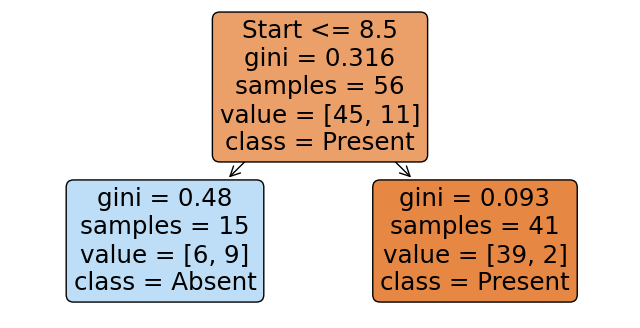

In [55]:
plt.figure(figsize = (8, 4))
fig = plot_tree(dtree_pruned, 
                filled = True, 
                rounded = True, 
                class_names= ["Present", "Absent"], 
                feature_names = ['Age', 'Number', 'Start'])

# Let's see with random Forest

for larger datasets it is better to use random forest

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
rfc = RandomForestClassifier(n_estimators = 200)

In [58]:
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [59]:
rfc_pred = rfc.predict(X_test)

In [60]:
print(print(confusion_matrix(y_test, rfc_pred)))
print()
print(classification_report(y_test, rfc_pred, target_names = ["present", "absent"]))

[[19  0]
 [ 5  1]]
None

              precision    recall  f1-score   support

     present       0.79      1.00      0.88        19
      absent       1.00      0.17      0.29         6

    accuracy                           0.80        25
   macro avg       0.90      0.58      0.58        25
weighted avg       0.84      0.80      0.74        25



In [61]:
RF = confusion_matrix(y_test, rfc_pred)

In [62]:
RF = pd.DataFrame(RF, index = ["Present", "Absent"], columns = ["Present", "Absent"])

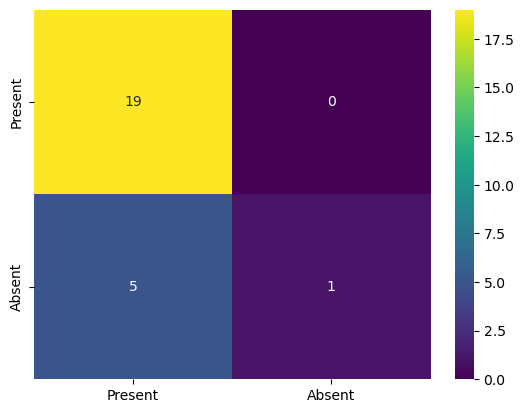

In [63]:
sns.heatmap(RF, annot = True, cmap = "viridis")
plt.show()

In [64]:
df["Kyphosis"].value_counts() # we have some imbalanced data here

absent     64
present    17
Name: Kyphosis, dtype: int64

1. Accuracy: Accuracy measures the proportion of predictions that are correct. It is the most commonly used classification metric, but it can be misleading for imbalanced datasets.


2. Precision: Precision measures the proportion of positive predictions that are actually correct. It is useful for evaluating models where false positives are costly.


3. Recall: Recall measures the proportion of actual positives that are correctly predicted. It is useful for evaluating models where false negatives are costly.


4. F1 score: The F1 score is a weighted average of precision and recall. It is a good overall measure of classification performance.

# Conclusion

We would be interested in predicting if the children have Kyphosis or not after an operation, and we need to make sure that They don't have this medical spinal condition, for this reason it is preferable to misclassify with our tree that it is present per baby  **(our algorithm predicts that it is present but the truth is that it is not)** than it is not preset when in reality it is   **(our algorithm predicts that it is absent but the truth is that it is not)** . 

We need to increase as much as we can the recall, the false negatives.

**Precisions:**

1. preliminary tree :precision = 80%

2. Tree optimized: precision = 81%

3. Tree with random forest: precision = 79%

**Recalls:**

1. preliminary tree : recall = 84%

2. Tree optimized: recall = 89%

3. Tree with random forest: recall = 100% <--- Look at this, this means that we did not misclassify any absent Kyphosis

For this reason our best tree to select on is the random forest tree classifier from the ensemble methods.